In [31]:
dpi = 300
image_save_dpi = 300

import matplotlib_inline

%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%config InlineBackend.figure_formats = ['retina'] 

import seaborn as sns
import matplotlib

sns.set(rc={"figure.dpi":dpi, 'savefig.dpi':dpi})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.dpi'] = dpi

In [32]:
import numpy as np
import pandas as pd

# Data

In [33]:
data = pd.read_excel('Data/Data_Volcano_Eruption.xlsx',skiprows=[0])
list1 = data[['Volcano Name', 'VEI', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']]
list1 = list1[
    (list1['Start Year']>=1800)]

## Data filtering

In [34]:
# Assuming list1 is already defined and contains the 'Start Year' data
list1 = list1['Start Year'].value_counts()

# Sort the index
list1 = list1.sort_index()

# Convert to DataFrame
list1 = list1.reset_index()

# Rename the columns
list1.columns = ['Year', 'Count']

# Now list1 has columns named 'Year' and 'Count'
list1 = list1.sort_values(by='Year', ascending=False)
list1

,Year,Count
191,2023,1
190,2022,1
189,2021,2
188,2020,3
187,2019,2
...,...,...
4,1806,2
3,1805,1
2,1804,2
1,1803,1


## Data processing

In [35]:
list2 = list1
list2['Repose'] = list1['Year'].diff(periods=-1)
list2 = list2.dropna(subset='Repose')
list2['Repose'].describe()



count    191.000000
mean       1.167539
std        0.426977
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Repose, dtype: float64

## stationarity check

ADF Statistic: -14.365825369222327
p-value: 9.676463173614748e-27
Critical values:
   1%, -3.4652439354133255
Critical values:
   5%, -2.8768752281673717
Critical values:
   10%, -2.574944653739612
Reject Ho - Time Series is Stationary


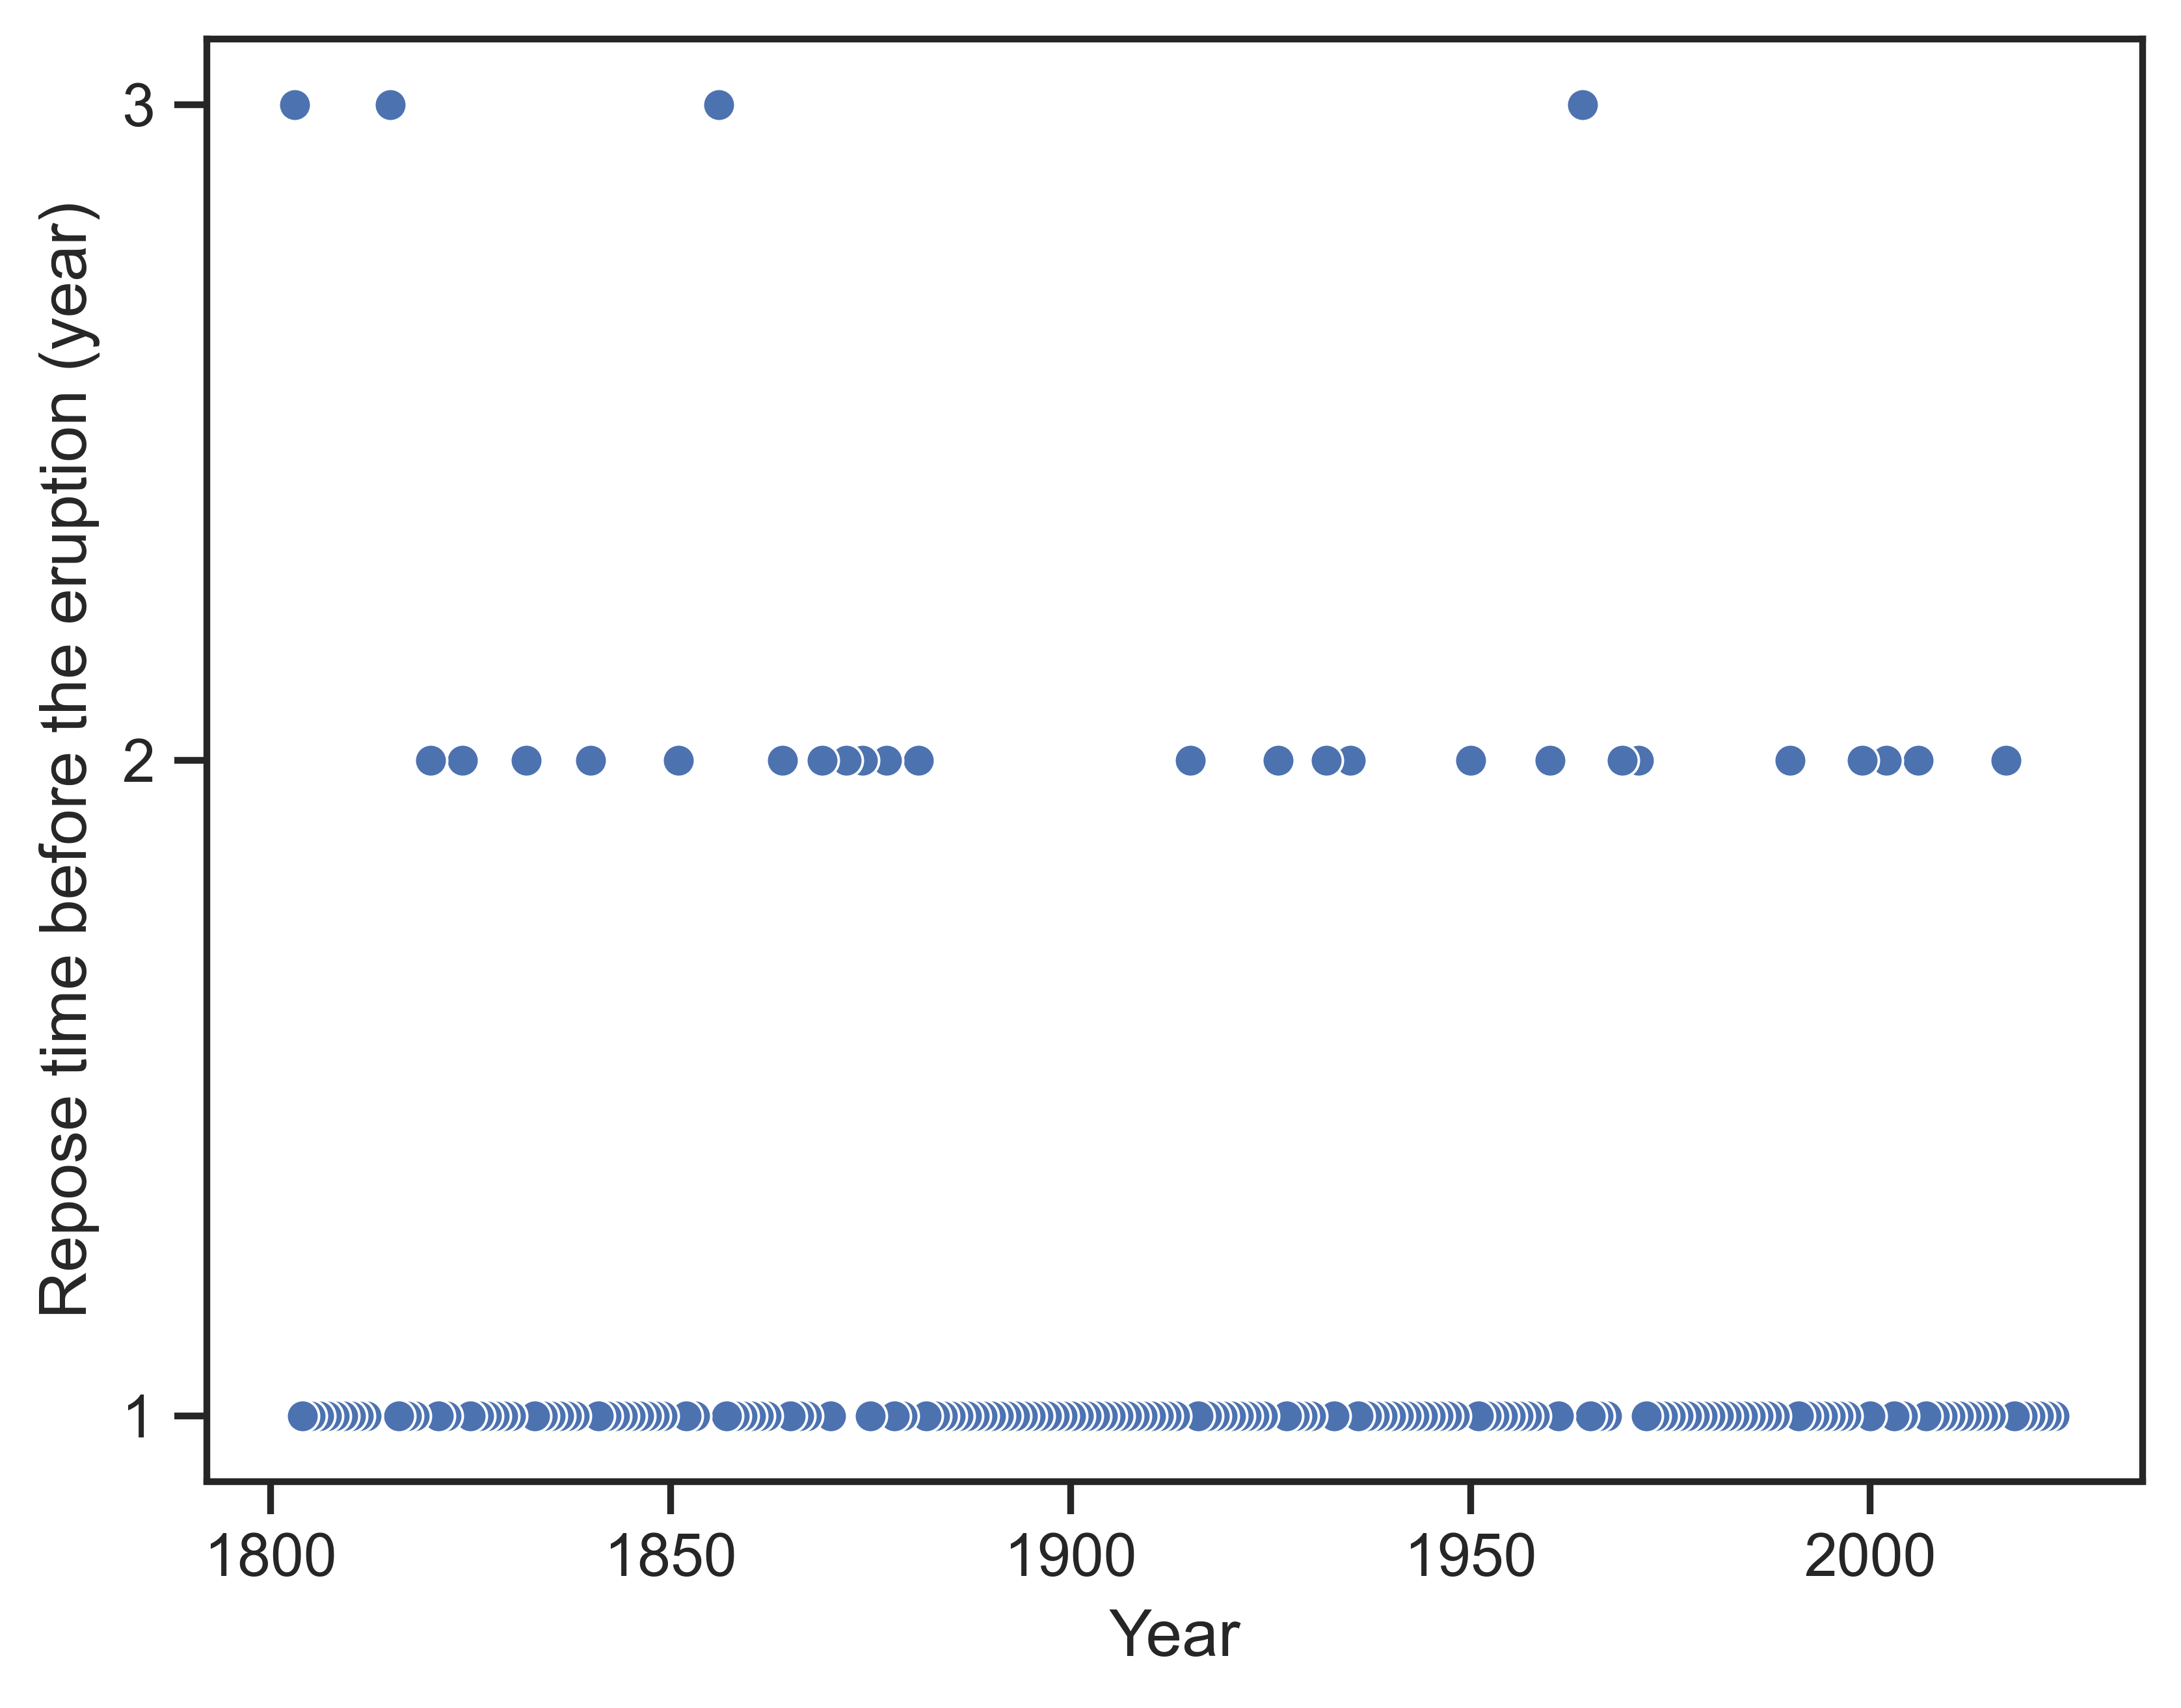

In [36]:
import seaborn as sns
sns.scatterplot(data=list2, x='Year', y='Repose')
plt.yticks(np.arange(1,4,1))
plt.ylabel('Repose time before the eruption (year)')

from statsmodels.tsa.stattools import adfuller, kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
result = adfuller(list2['Repose'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values:')
    print(f'   {key}, {value}')
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

## independence check

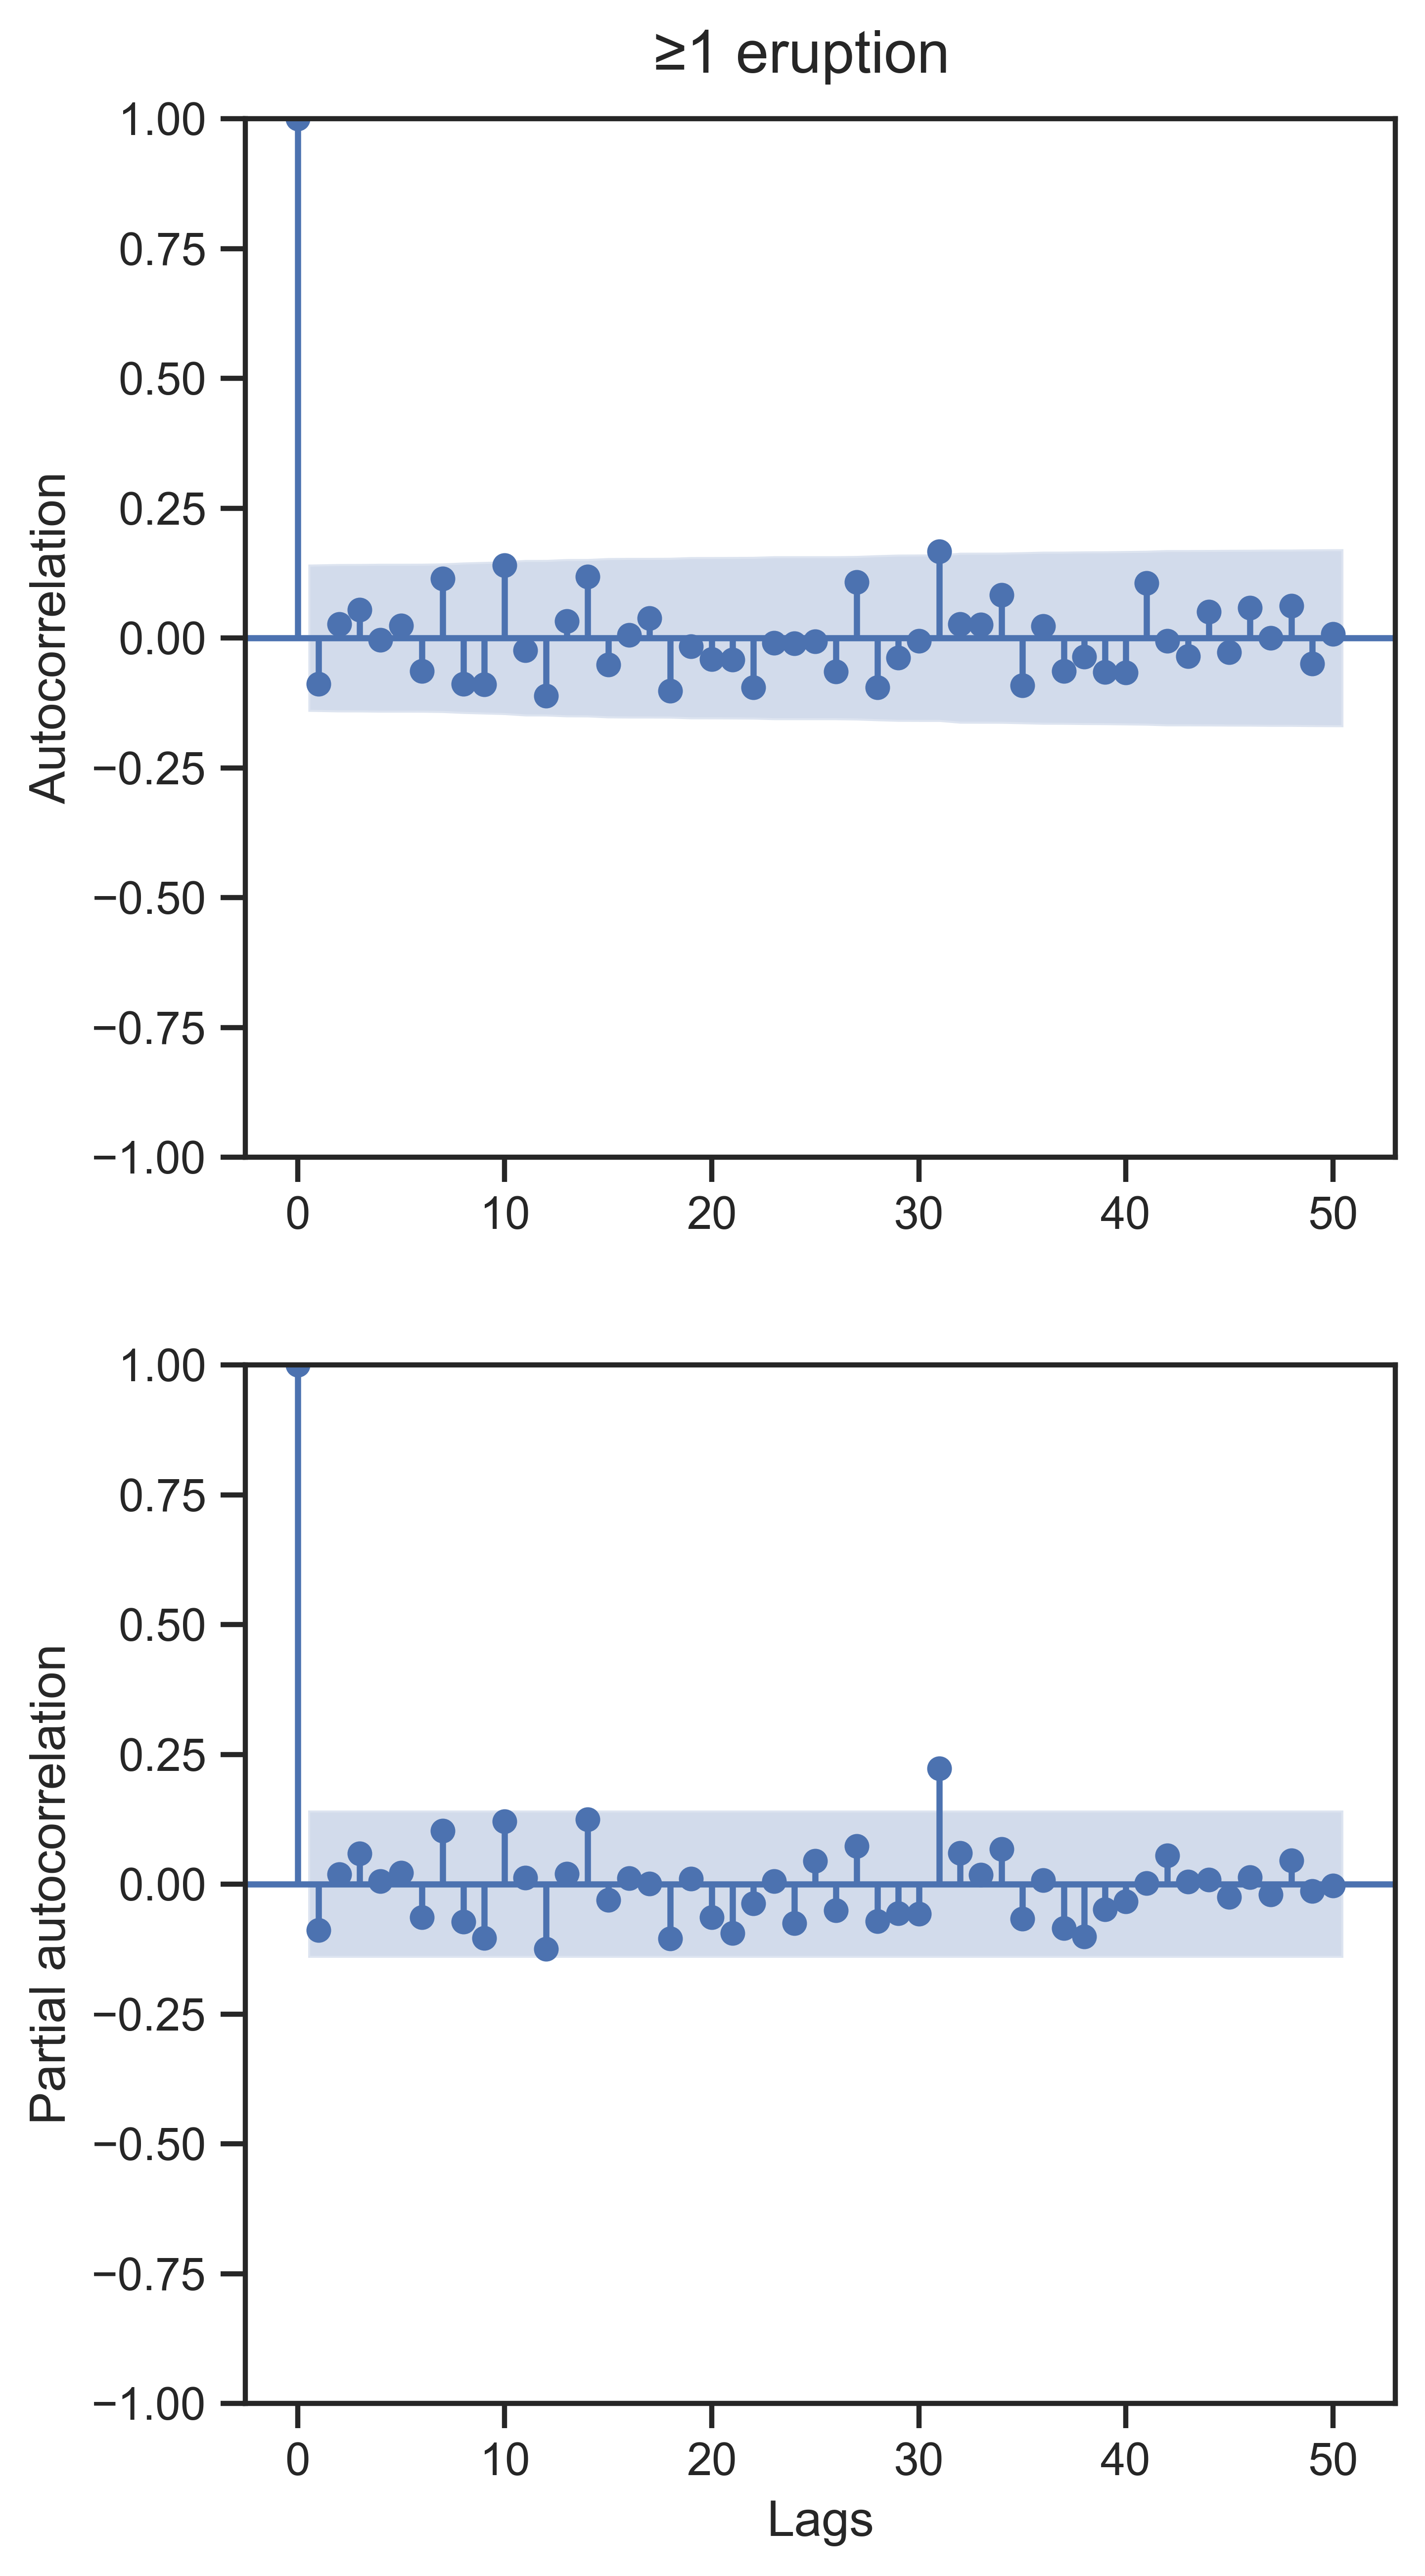

In [53]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

# Check autocorrelation
plot_acf(x=list2['Repose'], lags=50, ax=axs[0])
fig.suptitle('≥1 eruption',y=0.91)
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('')

# Check partial autocorrelation
plot_pacf(x=list2['Repose'], lags=50, ax=axs[1])
axs[1].set_ylabel('Partial autocorrelation')
axs[1].set_title('')
axs[1].set_xlabel('Lags')
plt.show()

## Descriptive statistic

In [ ]:
print('modus :', list2['Repose'].mode())
print('median: ', list2['Repose'].median())
print('variansi: ', list2['Repose'].var())
print(list2['Repose'].describe())

modus : 0    1.0
Name: Repose, dtype: float64
median:  1.0
variansi:  0.18230917608156513
count    191.000000
mean       1.167539
std        0.426977
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Repose, dtype: float64


## histogram repose time

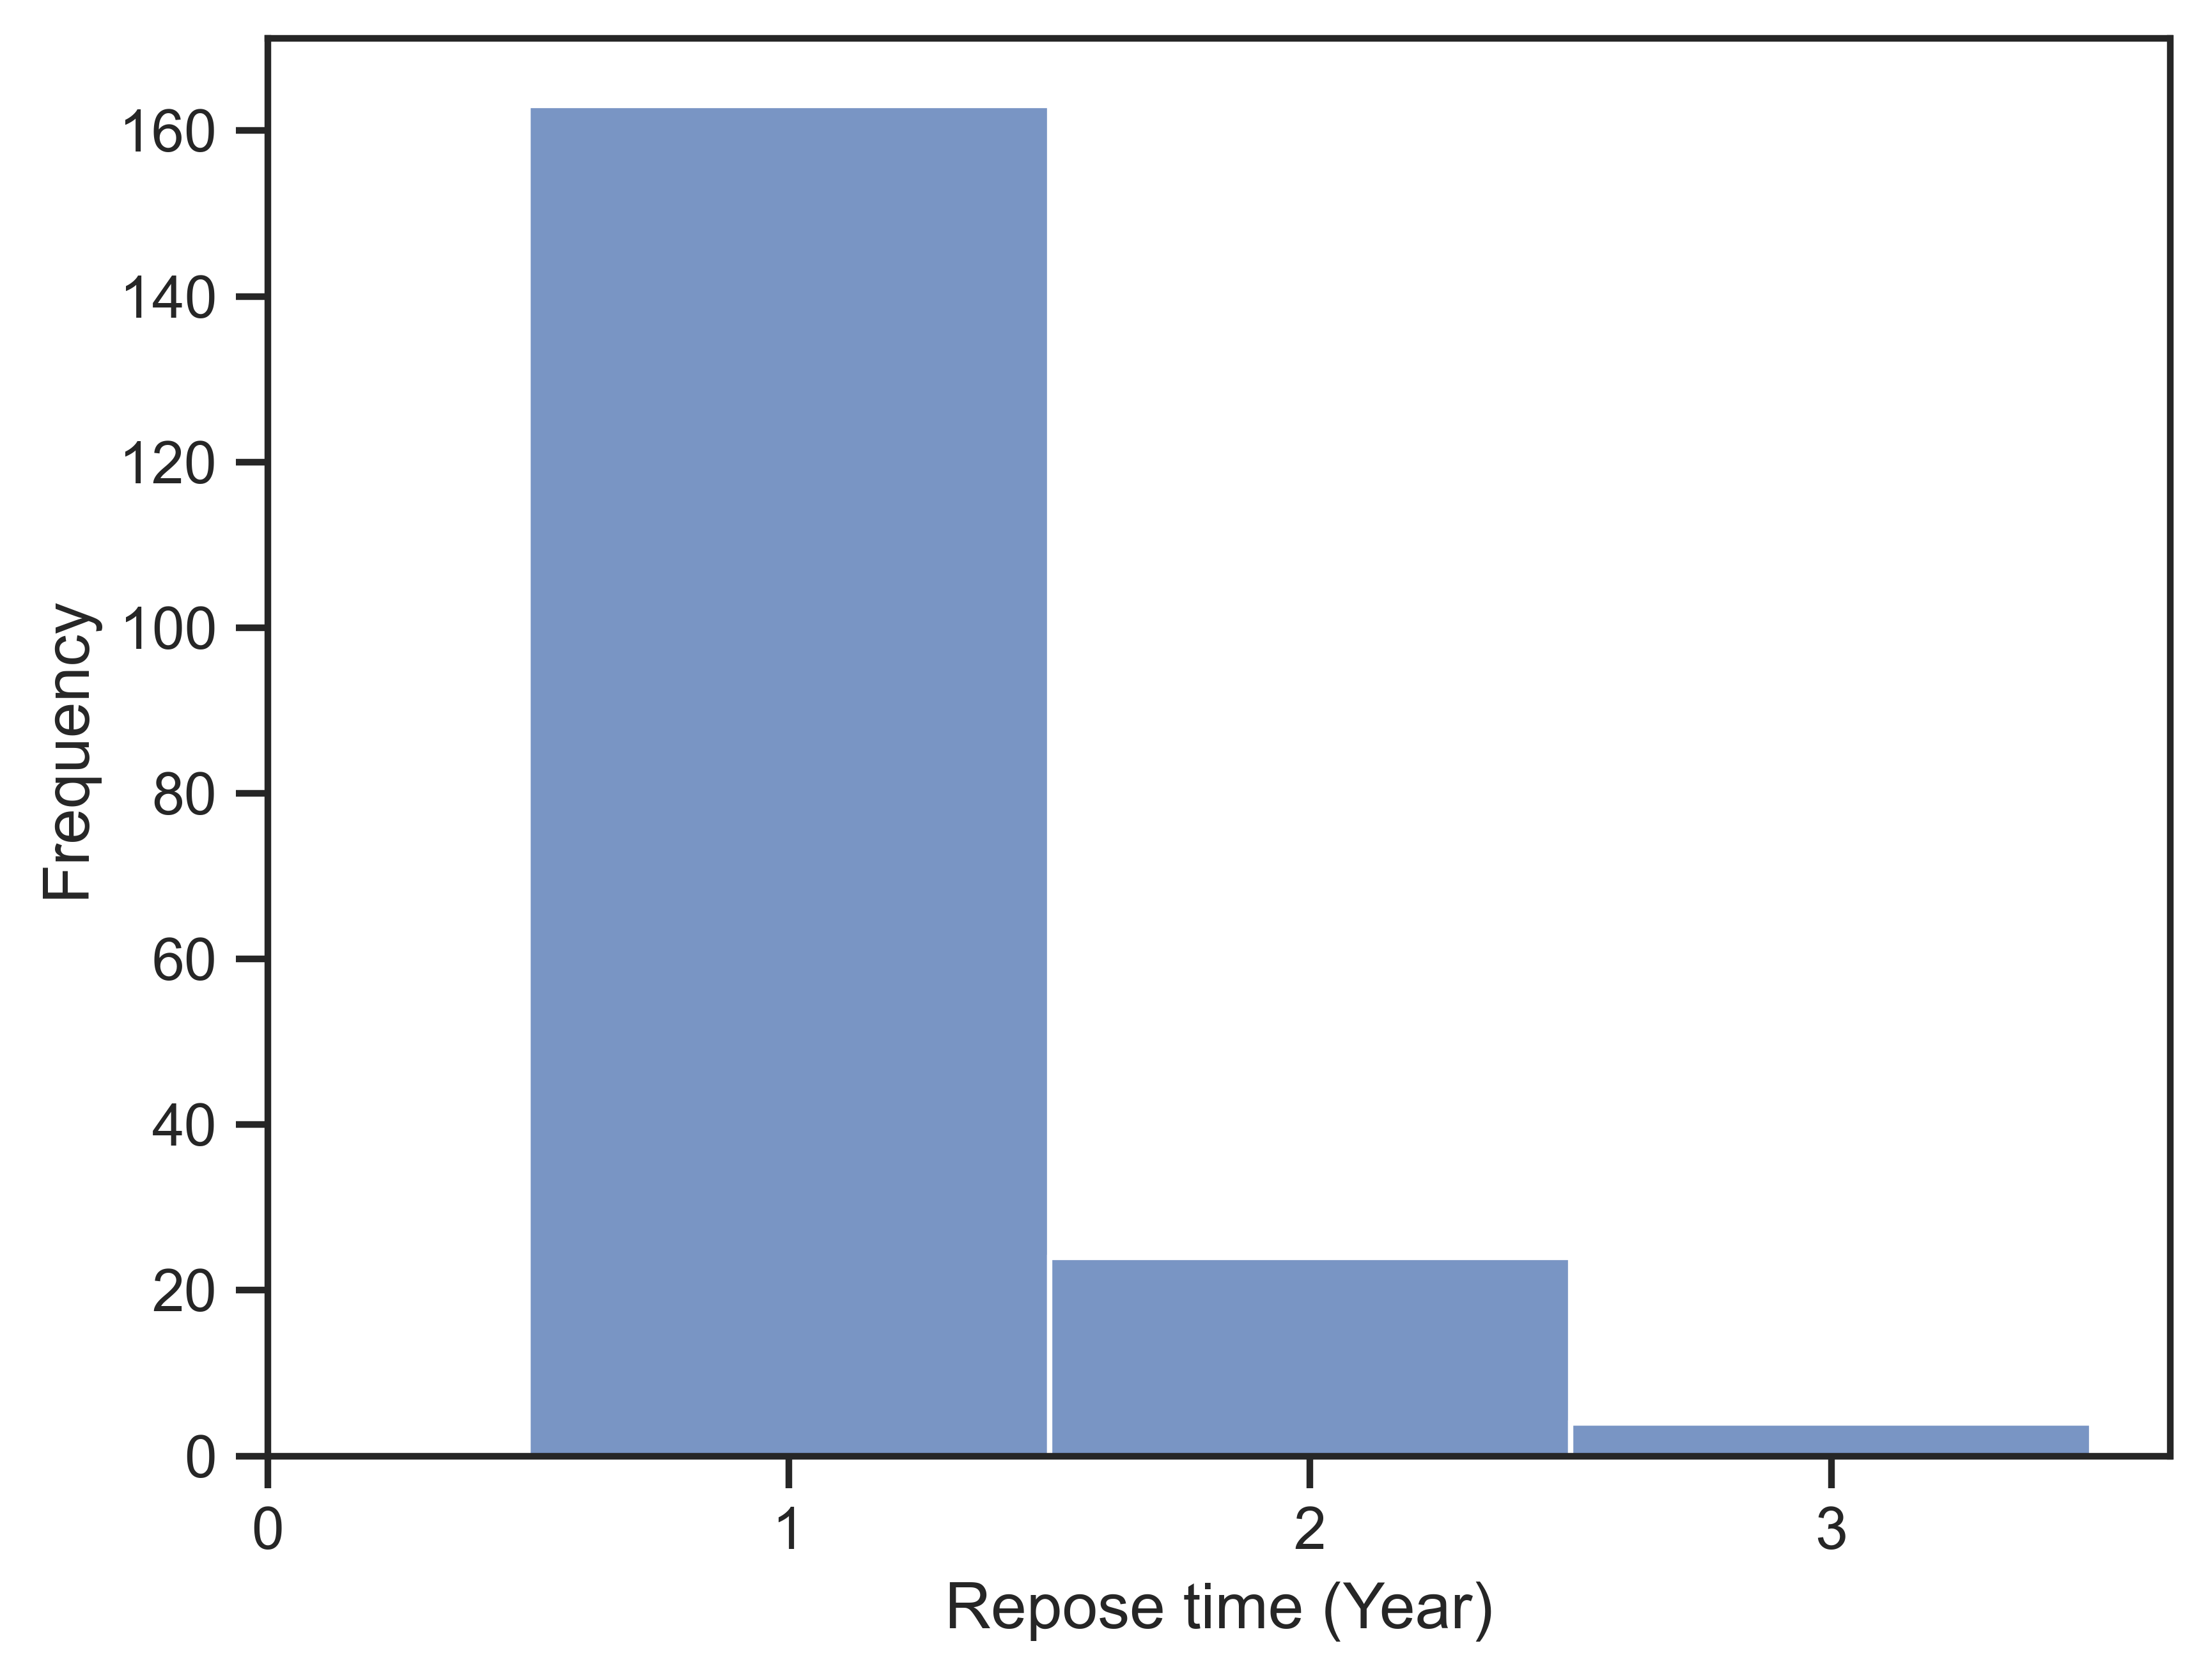

In [ ]:
import seaborn as sns
sns.histplot(data=list2.Repose, discrete=True)
plt.ylabel('Frequency')
plt.xlabel('Repose time (Year)')
plt.xticks(np.arange(0, 4, 1))
plt.show()

## Test

C:\Users\geika\AppData\Local\Temp\ipykernel_1936\686670322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list2.loc[list2.Repose >=0, 'Status'] = 1
C:\Users\geika\AppData\Local\Temp\ipykernel_1936\686670322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list2['Repose'] = list2['Repose'].replace([0], 0.5)


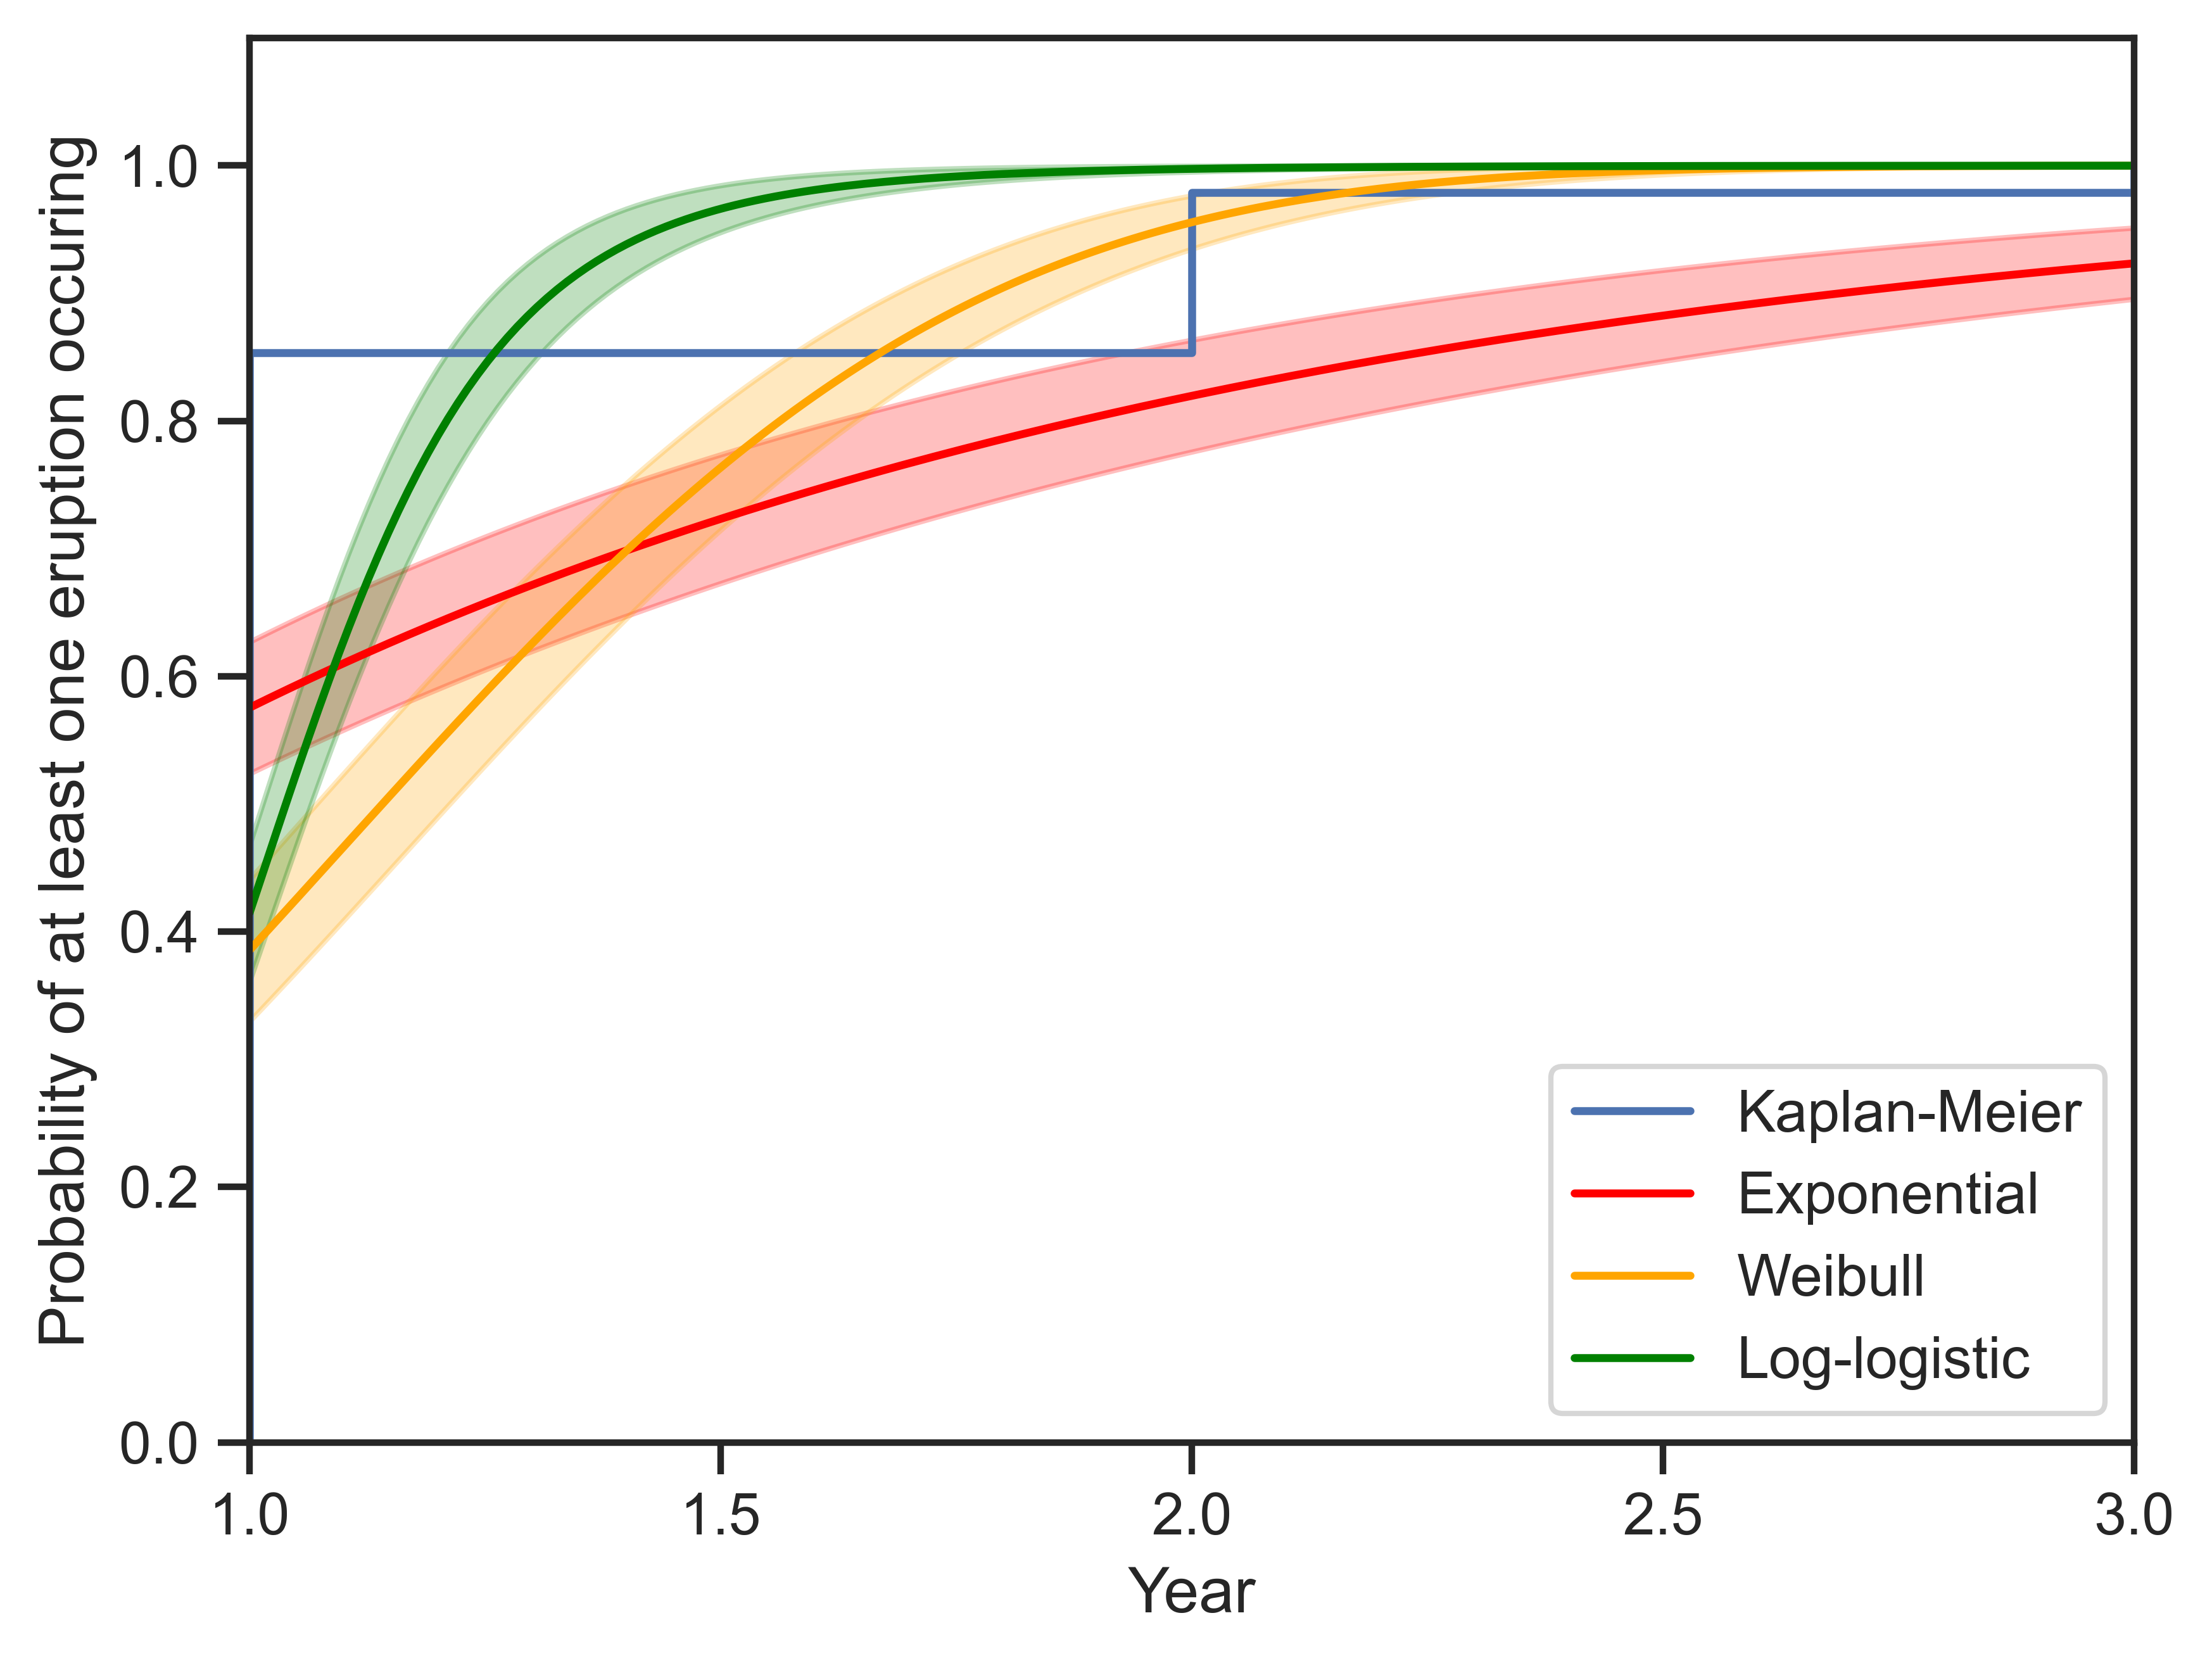

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
list2.loc[list2.Repose >=0, 'Status'] = 1
kmf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
list2['Repose'] = list2['Repose'].replace([0], 0.5)
kmf.plot_cumulative_density(ci_show=False, label='Kaplan-Meier')

#exponential
from lifelines import ExponentialFitter
exf = ExponentialFitter()
exf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
exf.plot_cumulative_density(ci_show=True, label='Exponential',color='red')

#weibull
from lifelines import WeibullFitter
wbf = WeibullFitter()
wbf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
wbf.plot_cumulative_density(ci_show=True, label='Weibull',color='orange')

#loglogistic
from lifelines import LogLogisticFitter
llf = LogLogisticFitter()
llf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
llf.plot_cumulative_density(ci_show=True, label='Log-logistic',color='green')
plt.ylabel('Probability of at least one eruption occuring')
plt.xlabel('Year')
plt.xlim(1,3)
plt.xticks(np.arange(1,3.5,0.5))
plt.ylim(0,1.1)
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(loc=4)
plt.show()

## Evaluation

In [ ]:
wbf.print_summary()
exf.print_summary()
llf.print_summary()

print(kmf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15,20]))
print(wbf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15,20]))
print(exf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15,20]))
print(llf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15,20]))

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 191 total observations, 0 right-censored observations>
   number of observations = 191
number of events observed = 191
           log-likelihood = -105.09
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  1.31      0.04            1.23            1.38
rho_     2.68      0.13            2.43            2.93

         cmp to     z      p  -log2(p)
lambda_    1.00  8.17 <0.005     51.50
rho_       1.00 13.26 <0.005    130.84
---
AIC = 214.18

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 191 total observations, 0 right-censored observations>
   number of observations = 191
number of events observed = 191
           log-likelihood = -220.59
               hypothesis = lambda_ != 0

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  1.17      0.08            1.00            1.33

         cmp to     z      p  -log2(p)
lambda_    0.00 13.82 <0.005    141.90
---
AIC = 443.17

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 191 total observations, 0 right-censored observations>
   number of observations = 191
number of events observed = 191
           log-likelihood = -11.88
               hypothesis = alpha_ != 1, beta_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
alpha_  1.04      0.01            1.01            1.06
beta_   9.12      0.65            7.84           10.40

        cmp to     z      p  -log2(p)
alpha_    1.00  2.95 <0.005      8.30
beta_     1.00 12.46 <0.005    115.99
---
AIC = 27.76

0.5     0.000000
1.0     0.853403
2.0     0.979058
3.0     1.000000
4.0     1.000000
5.0     1.000000
10.0    1.000000
15.0    1.000000
20.0    1.000000
Name: KM_estimate, dtype: float64
0.5     0.073246
1.0     0.385387
2.0     0.955614
3.0     0.999901
4.0     1.000000
5.0     1.000000
10.0    1.000000
15.0    1.000000
20.0    1.000000
Name: Weibull_estimate, dtype: float64
0.5     0.348352
1.0     0.575355
2.0     0.819677
3.0     0.923427
4.0     0.967484
5.0     0.986192
10.0    0.999809
15.0    0.999997
20.0    1.000000
Name: Exponential_estimate, dtype: float64
0.5     0.001271
1.0     0.414485
2.0     0.997466
3.0     0.999937
4.0     0.999995
5.0     0.999999
10.0    1.000000
15.0    1.000000
20.0    1.000000
Name: LogLogistic_estimate, dtype: float64
